Transfer-Learning is Machine Learning model that can be re-used for next model that has similar tasks.  It has advantages for saving times and work but will achieve similar outcome.

In [0]:
from torchvision import transforms, datasets, models
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch import nn
import torch.nn.functional as F


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [274]:
!git clone https://github.com/jaddoescad/ants_and_bees

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [275]:
# Check data folder dir
!ls

ants_and_bees  sample_data


In [276]:
#Check what is in folder
!ls ants_and_bees

train  val


In [277]:
!ls ants_and_bees/train

ants  bees


In [278]:
!ls ants_and_bees/train/ants

 0013035.jpg		     408393566_b5b694119b.jpg
 1030023514_aad5c608f9.jpg   424119020_6d57481dab.jpg
 1095476100_3906d8afde.jpg   424873399_47658a91fb.jpg
 1099452230_d1949d3250.jpg   450057712_771b3bfc91.jpg
 116570827_e9c126745d.jpg    45472593_bfd624f8dc.jpg
 1225872729_6f0856588f.jpg   459694881_ac657d3187.jpg
 1262877379_64fcada201.jpg   460372577_f2f6a8c9fc.jpg
 1269756697_0bce92cdab.jpg   460874319_0a45ab4d05.jpg
 1286984635_5119e80de1.jpg   466430434_4000737de9.jpg
 132478121_2a430adea2.jpg    470127037_513711fd21.jpg
 1360291657_dc248c5eea.jpg   474806473_ca6caab245.jpg
 1368913450_e146e2fb6d.jpg   475961153_b8c13fd405.jpg
 1473187633_63ccaacea6.jpg   484293231_e53cfc0c89.jpg
 148715752_302c84f5a4.jpg    49375974_e28ba6f17e.jpg
 1489674356_09d48dde0a.jpg   506249802_207cd979b4.jpg
 149244013_c529578289.jpg    506249836_717b73f540.jpg
 150801003_3390b73135.jpg    512164029_c0a66b8498.jpg
 150801171_cd86f17ed8.jpg    512863248_43c8ce579b.jpg
 154124431_65460430f2.jpg    518773929_7

In [0]:
# Data Arugment = configure parameters for images in different conditions: de-texturized, de-colorized, edge enhanced, salient edge map, flip/rotation

transform_train = transforms.Compose([transforms.Resize((224,224)),                #
                                       transforms.RandomHorizontalFlip(),
                                       #transforms.RandomRotation(10),
                                       transforms.RandomAffine(0, shear =10, scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=1, contrast=0.2, saturation=0.2), # jitter values closer to 1 will result in better performance
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
# Image preprocessing 
                              

transformation = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


# Divide into training and validation sets and load it

training_dataset = datasets.ImageFolder('ants_and_bees/train', transform = transform_train)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform = transformation)


training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle = False)

In [280]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [0]:
# Convert tensors to numpy array in order to work with matplotlib

def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image





In [282]:
!pip install Pillow==4.0

In [0]:
# Define all classes with names instead of number
classes = ('Ant', 'Bee')

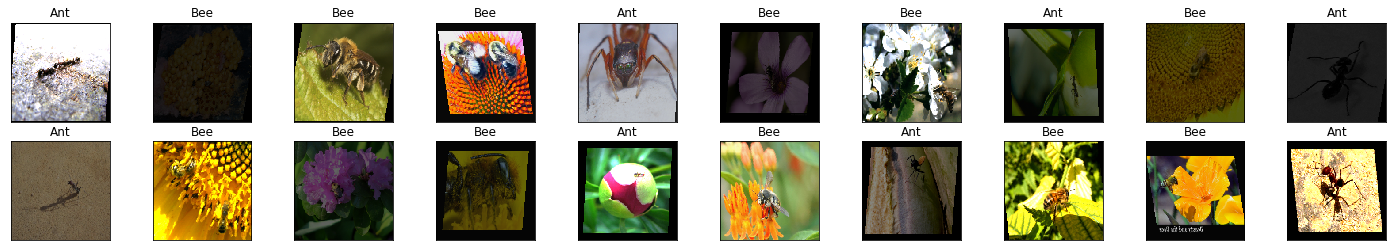

In [284]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])
  
            

In [0]:
#Defined pre-trained model from Pytorch
model = models.vgg16(pretrained=True)


In [286]:

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
for param in model.features.parameters(): # Loop throught all parameters in features extractions in model, allows feature extractions active
  param.requires_grad = False    # freeze classifier sequential EXCEPT (6)

In [0]:
import torch.nn as nn

In [289]:
n_inputs = model.classifier[6].in_features # choose (6) to output 2 classes
last_layer = nn.Linear(n_inputs, len(classes))

model.classifier[6] = last_layer
model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [291]:

epochs = 6
running_loss_history=[]
running_correct_history=[]
val_running_loss_history=[]
val_running_loss_corrects_history=[]

print("Initializing Training and Validation ........")
print("Please Wait...")

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.3f}, acc {:.3f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.3f}, validation acc {:.3f} '.format(val_epoch_loss, val_epoch_acc.item()))
print("-----Completed----- ")    

Initializing Training and Validation ........
Please Wait...
epoch : 1
training loss: 0.025, acc 0.758 
validation loss: 0.010, validation acc 0.941 
epoch : 2
training loss: 0.009, acc 0.926 
validation loss: 0.015, validation acc 0.908 
epoch : 3
training loss: 0.007, acc 0.955 
validation loss: 0.016, validation acc 0.902 
epoch : 4
training loss: 0.008, acc 0.939 
validation loss: 0.014, validation acc 0.928 
epoch : 5
training loss: 0.008, acc 0.934 
validation loss: 0.016, validation acc 0.935 
epoch : 6
training loss: 0.005, acc 0.967 
validation loss: 0.021, validation acc 0.908 
-----Completed----- 




> Indented block



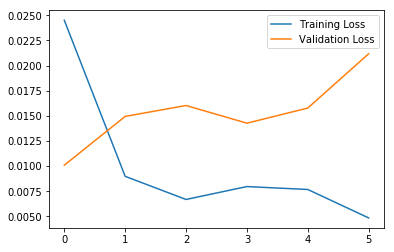

In [292]:
plt.plot(running_loss_history, label = "Training Loss")
plt.plot(val_running_loss_history, label = "Validation Loss")
plt.legend()

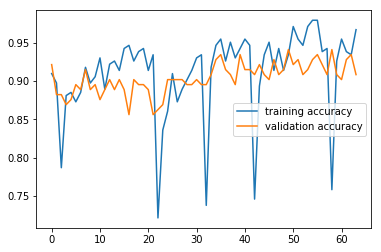

In [293]:



plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [0]:
import requests
from PIL import ImageOps
from PIL import Image

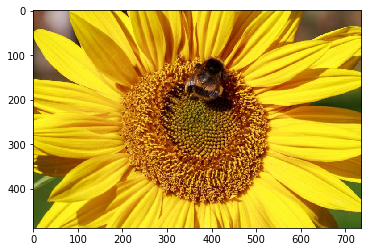

In [295]:
# Test image from online source.

url = 'https://d.newsweek.com/en/full/1139499/sunflowers-bee-stock.jpg?w=737&f=6906471a35de776ebe8d2252e28fe208'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)                   

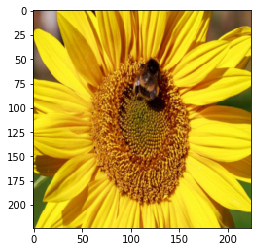

In [296]:

img = transformation(img)
plt.imshow(im_convert(img))
                         

In [299]:
# img = img.view(img.shape[0], -1)
# output = model(img)
# 
image = img.to(device).unsqueeze(0)

output = model(image)
_, pred = torch.max(output,1)
print('Prediction is: ',classes[pred.item()])


Prediction is:  Bee


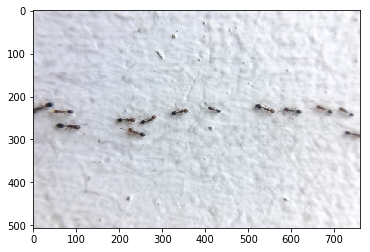

In [300]:
url = 'https://www.rd.com/wp-content/uploads/2015/02/ant-2-760x506.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)                   

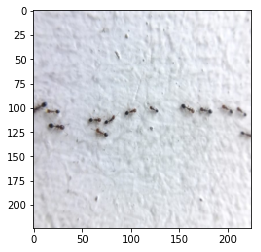

In [301]:
img = transformation(img)
plt.imshow(im_convert(img))
                         

In [302]:
image = img.to(device).unsqueeze(0)

output = model(image)
_, pred = torch.max(output,1)
print('Prediction is: ',classes[pred.item()])


Prediction is:  Ant


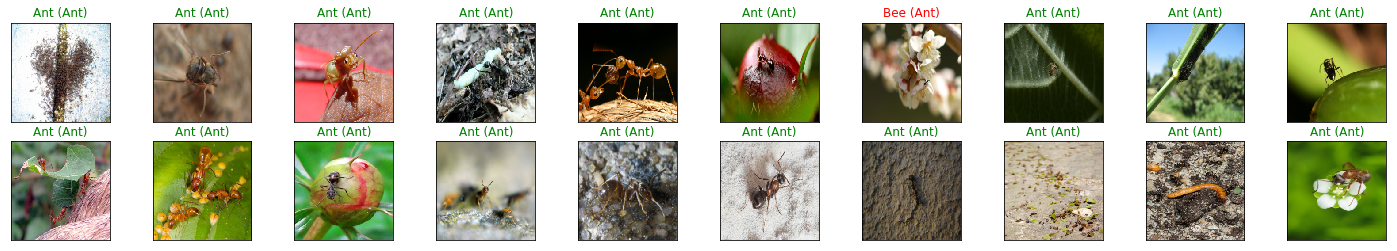

In [298]:
val_dataiter = iter(validation_loader)
images, labels = val_dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title('{} ({})'.format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=('green' if preds[idx] ==labels[idx] else 'red'))
  